In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Materials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1993-05-04,444.05,90.040001,-6.025142,-12.420968,-12.420968046317816,144.300,129.900,103.900,96.400,121.400,162.600
1,1993-05-05,444.52,89.930000,-5.979399,-13.077517,UNDERPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
2,1993-05-06,443.26,89.500000,-5.757537,-13.317191,UNDERPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
3,1993-05-07,442.31,89.239998,-5.426672,-13.055340,UNDERPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
4,1993-05-10,442.80,88.970001,-6.078989,-13.055801,UNDERPERFORM,144.300,129.900,103.900,96.400,121.400,162.600
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,551.250000,19.548197,15.757756,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7195,2021-11-26,4594.62,541.520020,16.437110,15.126395,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7196,2021-11-29,4655.27,544.190002,19.324593,17.262114,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397
7197,2021-11-30,4567.00,530.679993,17.908879,16.168291,UNDERPERFORM,280.126,250.105,263.553,309.682,272.154,326.397


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,2010,1,2010-01-14,1148.46,206.130005,-2.941027,-4.348026,UNDERPERFORM,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2010,2,2010-02-11,1078.47,187.250000,-9.326551,-13.506400,UNDERPERFORM,217.353,191.375,209.326,237.315,214.506,257.804,3
202,2010,3,2010-03-11,1150.24,199.759995,-8.476491,-15.986040,UNDERPERFORM,217.403,191.249,209.219,237.093,214.821,258.306,3
203,2010,4,2010-04-08,1186.44,210.339996,-7.551331,-10.134155,UNDERPERFORM,217.290,190.231,206.631,232.440,214.303,258.969,3
204,2010,5,2010-05-13,1157.44,195.979996,-12.792152,-20.083188,UNDERPERFORM,217.199,189.426,203.764,227.477,213.427,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,1.147999,-5.085445,UNDERPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,7.276877,-1.071539,UNDERPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,15.209058,10.151423,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,8.483351,9.204163,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [4]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [5]:
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
200,1,1148.46,206.130005,-2.941027,-4.348026,217.281,191.978,209.624,239.914,212.638,257.050,3
201,2,1078.47,187.250000,-9.326551,-13.506400,217.353,191.375,209.326,237.315,214.506,257.804,3
202,3,1150.24,199.759995,-8.476491,-15.986040,217.403,191.249,209.219,237.093,214.821,258.306,3
203,4,1186.44,210.339996,-7.551331,-10.134155,217.290,190.231,206.631,232.440,214.303,258.969,3
204,5,1157.44,195.979996,-12.792152,-20.083188,217.199,189.426,203.764,227.477,213.427,259.454,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,8
Size in Memory,10.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.70,0.46,2,100
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

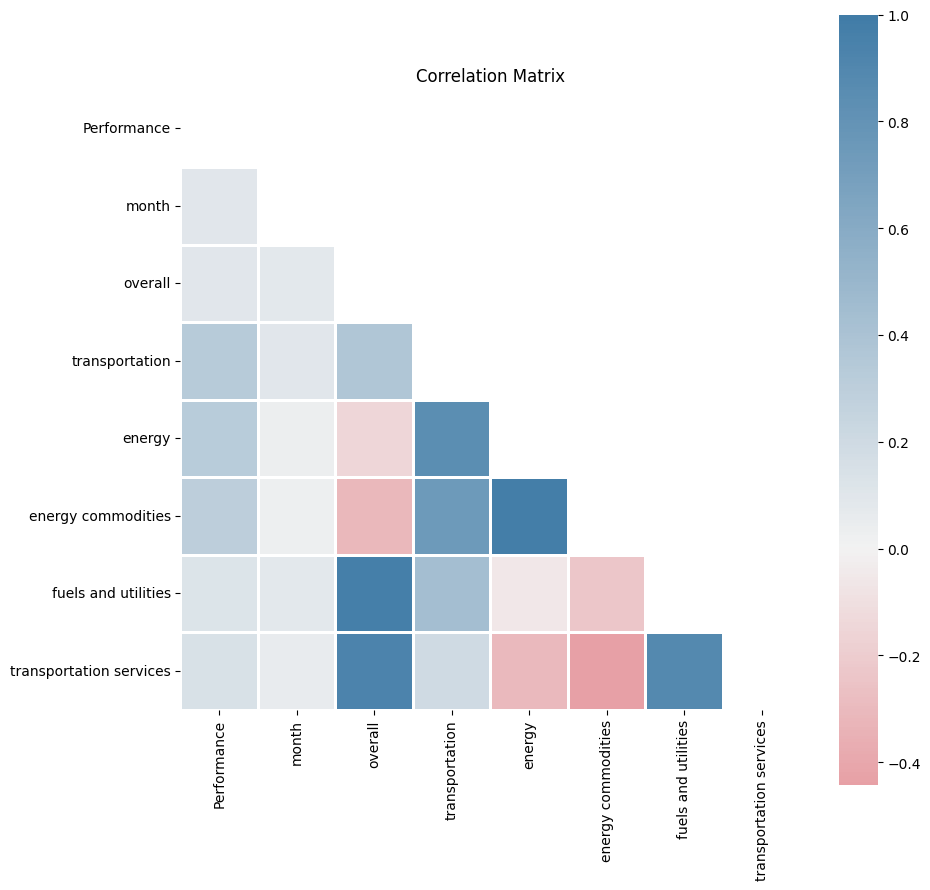

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,2,3027.357344,483.850144,4.277686,20.767562,244.870094,216.083778,249.641687,306.608817,224.887024,280.102967,3
1,6,3598.303780,536.054398,-11.260811,-6.207703,249.190060,193.709447,208.105555,196.104827,240.308745,321.400736,3
2,5,2008.544124,331.443089,-7.686579,0.316008,239.824965,210.545165,213.125719,228.166660,232.679568,321.334364,3
3,9,2095.185384,309.002339,-0.551670,-7.401046,244.927347,217.309967,246.627548,310.994955,229.542595,286.604881,3
4,8,1434.411274,198.286302,-12.332041,-2.633960,227.978546,218.516831,253.557471,320.507749,219.429421,274.130837,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,1447.038507,274.798281,-7.366746,-8.835645,221.483375,195.953933,248.211602,292.635448,224.496205,284.641192,3
9996,7,3182.584282,356.764763,-4.406225,-4.570011,247.515134,199.759108,224.118817,244.384255,241.648772,317.521003,3
9997,9,4194.761140,380.551819,-6.455779,7.879913,277.518794,212.973355,218.838342,228.694223,252.275712,332.124178,3
9998,10,1034.581094,209.976180,-8.230832,-15.670176,221.694171,192.309122,214.385364,221.087784,222.350502,276.678082,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
samples.head()

,Performance,month,overall,transportation,energy,energy commodities,fuels and utilities,transportation services
0,1,2,244.870094,216.083778,249.641687,306.608817,224.887024,280.102967
1,1,6,249.190060,193.709447,208.105555,196.104827,240.308745,321.400736
2,1,5,239.824965,210.545165,213.125719,228.166660,232.679568,321.334364
3,0,9,244.927347,217.309967,246.627548,310.994955,229.542595,286.604881
4,1,8,227.978546,218.516831,253.557471,320.507749,219.429421,274.130837


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.71,0.45,2,7126
month,int64,0,0,1,6,12,6.44,3.42,12,883
overall,float64,0,0,204.20,235.94,298.00,239.54,17.29,10000,1
transportation,float64,0,0,181.72,208.77,275.50,209.28,14.26,10000,1
energy,float64,0,0,175.91,216.85,270.58,223.14,21.52,10000,1
energy commodities,float64,0,0,154.73,239.86,347.44,253.90,45.061,9998,2
fuels and utilities,float64,0,0,206.14,230.74,295.51,231.64,14.37,10000,1
transportation services,float64,0,0,245.11,288.058,347.78,294.53,23.41,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

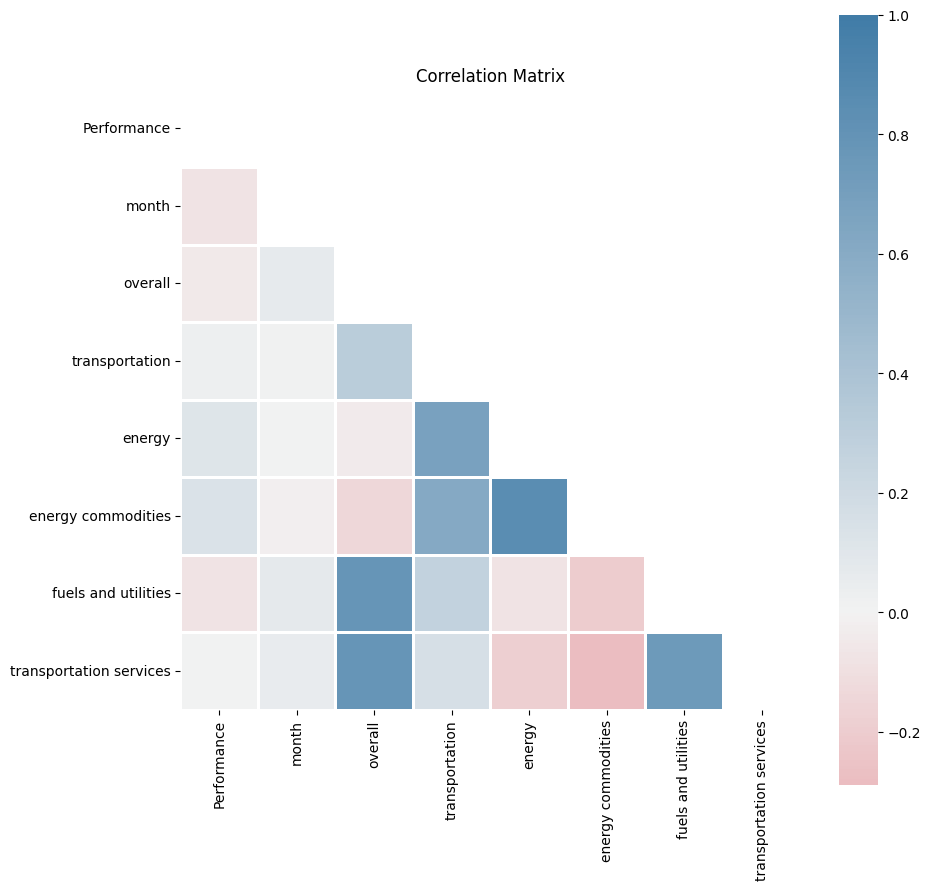

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 7126, 0: 2874})
Counter({1: 7126, 0: 7126})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  244.87009379,   216.08377832,   249.64168726, ...,
        68952.34445805, 85882.03946047, 62991.52271456],
       [  249.19005966,   193.70944683,   208.10555491, ...,
        47125.70491862, 63028.23580238, 77235.40770321],
       [  239.82496464,   210.54516504,   213.12571907, ...,
        53089.71985628, 73317.78852609, 74767.94113656],
       ...,
       [  221.81845007,   217.4997934 ,   255.15898695, ...,
        72031.79321503, 86914.04023471, 59482.88741545],
       [  267.48826161,   196.9516624 ,   213.69649465, ...,
        53692.57815472, 73029.49241664, 79215.82888691],
       [  240.95243866,   214.91888721,   244.81589285, ...,
        73018.14422346, 85717.90386574, 68761.15863331]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(14252, 22)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 22)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.733376,0.797769,0.630365,0.703219,0.716812,0.784005,0.62337,0.69452,0.538462,0.717949,0.56,0.629213
1,DecisionTreeClassifier,0.713939,0.737451,0.670081,0.701336,0.689587,0.726543,0.639674,0.680347,0.517483,0.706667,0.53,0.605714
2,RandomForestClassifier,0.81105,0.847075,0.766203,0.803148,0.788661,0.831605,0.740761,0.783558,0.636364,0.785714,0.66,0.717391
3,AdaBoostClassifier,0.642929,0.642583,0.645234,0.643714,0.648891,0.663884,0.64837,0.656035,0.65035,0.837838,0.62,0.712644
4,GradientBoostingClassifier,0.668118,0.66317,0.683689,0.673128,0.672467,0.684789,0.677717,0.681235,0.657343,0.822785,0.65,0.726257
5,ExtraTreesClassifier,0.850132,0.884221,0.812091,0.845189,0.827673,0.865316,0.78913,0.825469,0.699301,0.776699,0.8,0.788177
6,BaggingClassifier,0.759828,0.821039,0.670077,0.736817,0.746281,0.819236,0.652717,0.726558,0.531469,0.73913,0.51,0.60355
7,SVC,0.648682,0.636939,0.691409,0.663008,0.648611,0.653445,0.680435,0.666667,0.706294,0.822222,0.74,0.778947
8,GaussianNB,0.612546,0.604684,0.650294,0.626555,0.618019,0.62339,0.657609,0.640042,0.748252,0.855556,0.77,0.810526


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.806343,0.846803,0.763043,0.802744


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Materials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
80,2000,1,2000-01-13,1449.68,161.000000,5.081257,46.911220,OUTPERFORM,170.000,150.000,118.800,122.400,134.500,193.600,3
81,2000,2,2000-02-10,1416.83,134.789993,5.594103,19.632551,OUTPERFORM,171.000,153.600,124.300,133.400,133.600,194.400,3
82,2000,3,2000-03-09,1401.69,122.080002,9.948543,-2.964785,UNDERPERFORM,170.900,152.100,120.900,126.100,133.700,194.700,3
83,2000,4,2000-04-13,1440.51,144.729996,4.861217,14.329726,OUTPERFORM,171.200,152.000,120.000,124.100,133.800,195.500,3
84,2000,5,2000-05-11,1407.81,138.949997,11.913923,7.496520,UNDERPERFORM,172.200,155.000,126.800,134.900,136.600,196.000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,1.147999,-5.085445,UNDERPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,7.276877,-1.071539,UNDERPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,15.209058,10.151423,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,8.483351,9.204163,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [23]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,8,1375.780019,160.350295,9.755604,16.624249,237.201945,184.665178,192.905980,213.769091,198.607568,229.122725,3
1,8,2228.294068,448.137494,-13.124405,-4.013094,265.290501,202.756516,195.902940,201.929479,258.840603,320.015968,3
2,6,1078.515569,139.784269,-1.062353,-6.061819,175.727886,155.236368,140.241569,140.567305,156.201615,192.718676,3
3,9,2438.368475,260.650792,77.332701,3.254678,221.443500,221.783396,258.628801,324.394717,233.729833,288.527027,3
4,8,1068.778121,165.169392,14.592520,-5.373258,177.447671,154.073575,141.382553,145.720822,154.085307,240.106170,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,1158.870315,133.824268,13.765580,-4.769374,178.552936,155.604143,143.715325,154.329417,143.865757,207.689136,3
9996,9,1050.816662,125.946986,3.759981,-13.150329,184.826869,155.022097,144.185984,138.841021,161.279894,207.633866,3
9997,12,3089.210735,468.389831,-19.606675,-12.323363,268.045210,202.920902,193.050402,169.855551,262.900501,335.003029,3
9998,8,1208.896091,177.654071,-12.154940,72.821482,234.165690,199.723808,229.426781,303.453321,219.094412,304.329689,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.6859,0.670203,0.730339,0.698635,0.672877,0.653947,0.719768,0.685281,0.69962,0.706767,0.701493,0.70412
1,DecisionTreeClassifier,0.644151,0.640152,0.654541,0.645915,0.637764,0.629552,0.650978,0.640085,0.60076,0.623932,0.544776,0.581673
2,RandomForestClassifier,0.718511,0.702,0.757751,0.727918,0.697241,0.676084,0.745112,0.708922,0.714829,0.718519,0.723881,0.72119
3,AdaBoostClassifier,0.699515,0.677142,0.762762,0.717323,0.684701,0.660064,0.748009,0.70129,0.756654,0.730263,0.828358,0.776224
4,GradientBoostingClassifier,0.708385,0.687403,0.764555,0.723869,0.689359,0.665593,0.748009,0.704398,0.756654,0.746479,0.791045,0.768116
5,ExtraTreesClassifier,0.725229,0.706223,0.768323,0.734546,0.705482,0.684488,0.750905,0.71616,0.707224,0.714286,0.708955,0.71161
6,BaggingClassifier,0.692889,0.701369,0.668163,0.683109,0.691508,0.695783,0.66908,0.682171,0.642586,0.666667,0.597015,0.629921
7,SVC,0.703099,0.667998,0.807917,0.731281,0.687567,0.651218,0.793628,0.715405,0.771863,0.756944,0.813433,0.784173
8,GaussianNB,0.6919,0.651937,0.823686,0.727775,0.674669,0.635841,0.801593,0.709161,0.741445,0.708861,0.835821,0.767123


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Materials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),S&P 500 Materials (Sector) Outperform/Underperform,overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,1993,5,1993-05-13,439.23,90.330002,-5.758792,-10.732286,UNDERPERFORM,144.300,129.900,103.900,96.400,121.400,162.600,3
1,1993,6,1993-06-10,445.38,89.989998,-4.085280,-12.298999,UNDERPERFORM,144.500,130.100,103.400,95.300,121.700,163.200,3
2,1993,7,1993-07-08,448.64,89.849998,-0.020057,-3.759643,UNDERPERFORM,144.800,130.500,103.400,95.000,122.100,163.900,3
3,1993,8,1993-08-12,448.96,89.269997,-1.830188,-11.640109,UNDERPERFORM,145.000,130.400,103.000,93.900,122.500,164.000,3
4,1993,9,1993-09-09,457.50,89.269997,3.319783,-9.121455,UNDERPERFORM,145.600,132.000,105.300,98.300,122.600,164.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,511.019989,1.147999,-5.085445,UNDERPERFORM,273.092,236.783,242.958,276.734,262.483,326.470,3
339,2021,8,2021-08-12,4460.83,541.940002,7.276877,-1.071539,UNDERPERFORM,274.214,237.107,245.847,280.047,265.333,323.329,3
340,2021,9,2021-09-09,4493.28,525.940002,15.209058,10.151423,UNDERPERFORM,276.590,241.826,255.010,293.342,270.870,323.995,3
341,2021,10,2021-10-14,4438.26,526.789978,8.483351,9.204163,OUTPERFORM,278.524,246.749,261.257,305.653,271.467,326.256,3


In [26]:
original = data[['S&P 500 Materials (Sector) Outperform/Underperform','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
data.drop(columns=['date','S&P 500 Materials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Materials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Materials (Sector),S&P 500 Performance (%),S&P 500 Materials (Sector) Performance (%),overall,transportation,energy,energy commodities,fuels and utilities,transportation services,dow
0,5,900.420445,103.066434,-15.013985,-18.616738,228.107286,149.343784,214.485854,99.007239,127.745840,247.068606,3
1,5,2479.918405,267.133479,-4.265518,-1.558215,243.494685,208.416550,207.391495,176.483023,233.629167,251.966845,3
2,5,2826.671963,155.090922,-15.403660,-10.371326,236.789463,201.816573,190.215866,208.751506,231.583545,307.985735,3
3,1,406.110673,105.629094,-11.777114,-10.720746,155.906899,157.777690,111.216266,108.757709,146.394636,175.244261,3
4,10,1459.837245,239.888475,-0.877492,3.065554,256.360009,203.508505,229.047997,228.933593,240.921087,344.297688,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,3375.798848,328.068702,11.860128,30.941440,241.915094,197.055955,185.875089,166.483798,237.847669,320.681954,3
9996,2,1705.943879,285.971447,-7.462794,-3.133149,211.218000,176.970674,164.047417,152.471396,213.146334,247.862583,3
9997,7,2417.036028,153.077367,-7.108581,-13.697855,192.578769,181.787252,180.570029,199.931105,208.225928,228.845294,3
9998,5,927.717768,99.281703,20.928768,3.499340,172.021640,136.912837,109.082462,94.634518,144.329653,190.027438,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Materials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','transportation',\
                 'energy', 'energy commodities', 'fuels and utilities','transportation services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.612262,0.617791,0.589345,0.603106,0.626919,0.637521,0.590409,0.613061,0.562682,0.647399,0.557214,0.59893
1,DecisionTreeClassifier,0.576252,0.576674,0.578119,0.576999,0.571822,0.5721,0.573899,0.572998,0.408163,0.494048,0.412935,0.449864
2,RandomForestClassifier,0.646499,0.654765,0.620822,0.637147,0.650531,0.659468,0.624214,0.641357,0.620991,0.717791,0.58209,0.642857
3,AdaBoostClassifier,0.644135,0.676857,0.55175,0.607825,0.639906,0.681587,0.52673,0.594235,0.690962,0.806452,0.621891,0.702247
4,GradientBoostingClassifier,0.650334,0.672941,0.585795,0.626169,0.655647,0.684651,0.578616,0.627184,0.6793,0.782609,0.626866,0.696133
5,ExtraTreesClassifier,0.642661,0.652666,0.610792,0.630901,0.647776,0.657741,0.617925,0.637211,0.618076,0.713415,0.58209,0.641096
6,BaggingClassifier,0.623081,0.645604,0.547029,0.592132,0.616293,0.63814,0.539308,0.584576,0.562682,0.683453,0.472637,0.558824
7,SVC,0.623475,0.656332,0.518897,0.579278,0.62377,0.661224,0.509434,0.575488,0.717201,0.837662,0.641791,0.726761
8,GaussianNB,0.548997,0.558412,0.469891,0.510285,0.550571,0.561321,0.467767,0.510292,0.475219,0.576642,0.393035,0.467456
